In [1]:
import pandas as pd
import numpy as np
import handcalcs.render
import forallpeople
from math import pi
from IPython.display import display, Markdown, Math
forallpeople.environment('structural_custom', top_level = True)
%decimal_separator ,

# Cálculo da Área de Armadura através de processo iterativo - DIN1045-1

## Definição das propriedades

In [2]:
%%render params 3
f_yk = 500 * MPa
f_yd = f_yk / 1.15
f_tkcal = 525 * MPa
f_tdcal = f_tkcal / 1.15
E_s = 200000 * MPa
ε_yd = f_yd / E_s
f_ck = 30 * MPa
α = 0.85
f_cd = α * f_ck / 1.5

# Parâmetros do uso do diagrama retangular:
α_R = 0.81 
k_a = 0.416 # $\alpha_R$, $k_a$: parâmetros do diagrana parábola-retângulo

<IPython.core.display.Latex object>

In [11]:
#%%render 2
h = .24 * m
d = .205 * m
b= 1 *  m

z_s1 = h/2 - (h-d)

M_Ed = 77.39 * kN * m
N_Ed = 0 * kN
# e_d = M_Ed / N_Ed # Dá erro quando N=0, duh
h_kern = (h/6)
M_Eds = M_Ed - N_Ed * z_s1

# 1º passo de iteração
A ruptura é definida pela zona de concreto em compressão ou pelo aço? Assumindo que o plano de deformação está entre os domínios 2 e 3:

In [12]:
ε_c2u = - 3.5 * mm / m
ε_su = 25 * mm / m
ξ_23 =  ε_c2u / (ε_c2u - ε_su)
x = ξ_23 * d

In [13]:
x = ξ_23 * d
z = d - k_a * x
ζ = z/d
print(f'x = {x}\n',f'z = {z}\n',f'ζ = {ζ}\n')

x = 25.175 mm
 z = 194.527 mm
 ζ = 0.9489122807017545



In [14]:
%%render
F_cd = - α_R*b*x*f_cd
M_Rds = -F_cd*z
M_Eds = M_Eds

<IPython.core.display.Latex object>

In [15]:
if M_Rds > M_Eds:
    print("Viga no estádio 2" + " - completar código para estádio 2")
else:
    print("Viga no estádio 3 ou 4 - seguir com cálculo")

Viga no estádio 3 ou 4 - seguir com cálculo


# 2º Passo de iteração
O aço alcança a tensão de escoamento no ELU?

In [16]:
ξ_34 =  ε_c2u / (ε_c2u - ε_yd); print(ξ_34)
x = ξ_34 * d; print(x)
z = d - k_a * x; print(z)
ζ = z/d; print(ζ)

0.6168582375478927
126.456 mm
152.394 mm
0.7433869731800766


In [17]:
%%render
F_cd = - α_R*b*x*f_cd 
M_Rds = -F_cd*z
M_Eds = M_Eds

<IPython.core.display.Latex object>

In [18]:
if M_Rds > M_Eds:
    print("Viga no estádio 3 - Seguir com cálculo no estádio 3")
else:
    print("Viga no estádio 4 - Ruptura sem aviso - Redimensionar")

Viga no estádio 3 - Seguir com cálculo no estádio 3


In [19]:
# Criar algoritmo para iterar até chegar em M_Rds = M_Eds, variando ε_s1

#Calculadora do momento em função da deformação no aço, para o dominio 3
def calc_M(ε_sd):
    global ξ, x, z, ζ, F_cd, M_Rds
    ξ = ε_c2u / (ε_c2u - ε_sd)#; print(ξ)
    x = ξ * d# ; print(x)
    z = d - k_a * x#; print(z)
    ζ = z/d#; print(ζ)
    F_cd = - α_R*b*x*f_cd#; print(α_R, b, x, f_cd,F_cd)
    M_Rds = - F_cd * z
    
    return M_Rds
     

In [20]:
pts=1000
ε_list = []
M_list = []
M_Ed_list = [] 

for e in range(0,pts+1,1):
    ε = (((pts-e)/pts)*ε_yd + (e/pts)*ε_su)
    ε_list.append(float(ε))
    
    M = calc_M(ε)
    M_list.append(float(M))
    M_Ed_list.append(float(M_Eds.prefix('k')))
    
    

In [21]:
print(M_Eds)

77.390 kN·m


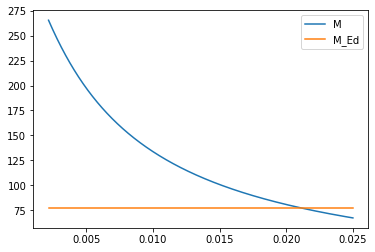

In [22]:
# Plotando o gráfico para ver se faz sentido: Gráfico de MRds variando com ε

data={'M':M_list,'M_Ed':M_Ed_list }

dados = pd.DataFrame(data, index=ε_list)

#dados.plot.scatter(x='ε', y='M', ='M_Ed_list')

lines = dados.plot.line()

In [23]:
# Como pegar o ponto exato??

def find_match_dom3(M_Ed_list, M_lis):
    global M_subtract
    M_Ed_array = np.array(M_Ed_list)
    M_array = np.array(M_list)
    M_subtract = M_Ed_array - M_array
    for i in range(M_subtract.size):
        if M_subtract[i] > 0:
            print(i, i-1,M_array[i-1],M_array[i])
            return i-1
            break

In [24]:
pos=find_match_dom3(M_Ed_list, M_list)

831 830 77.40238686943906 77.33519206989168


In [25]:
# Agora tenho um intervalo pequeno o bastante pra que haja convergencia...
# Aqui escrevi uma função para buscar o valor de M que bate com M_Eds

M_Eds_float = float(M_Eds)

pts = 1000
ε_list_narrowed = [((pts-i)/pts)*ε_list[pos]+(i/pts)*ε_list[pos+1] for i in range(pts)]

def converjator(M_Eds):
    for ε in ε_list_narrowed:
        M = float(calc_M(ε))
        #print(M - float(M_Eds), M)
        if abs(M-M_Eds) < 1E-3:
            return [M, ε]

In [26]:
Ans=converjator(float(M_Eds))

In [27]:
M_Ans = Ans[0]
ε_Ans = Ans[1]

In [28]:
calc_M(ε_Ans)

77.391 kN·m

In [29]:
%%render 2
ε_sd = Ans[1]
M_Eds
M_Rds = Ans[0] * kN * m
ξ
x=x.prefix('c') 
z=z.prefix('c') 
ζ
F_cd
σ_s1d = f_yd + ((ε_sd - ε_yd)/(ε_su - ε_yd))*(f_tdcal - f_yd)
erfA_s1 = ((-F_cd+N_Ed)* (σ_s1d) ** -1).prefix('c')

<IPython.core.display.Latex object>

# Completar
* Da maneira como fiz, está completo para os casos que caem no domínio 3.
* Certamente existem maneiras melhores de calcular, principalmente para a parte que procurar o valor que bate com M_Esd
* Também provavelmente existe uma "arquitetura" melhor do notebook geral
* Tem um probleminha acontecendo quando usa letras gregas, não sei se é conflito com o handcalcs ou forallpeople...

## Da maneira como está, é só um estudo para fazer uma biblioteca para cálculo de armadura sem precisar de notebook, ou fechar as lógicas num package